In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
from functions.functions import *

CUDA is available. Using GPU.


**PART 1**

# Function Defiinitions

- ``calculate_metrics``:  Calcuoates the RMSE and PSNR of the reconstructed/ predicted image.
- ``Normalize``: Divides all the pixel values by 255( to normalize it between 0 and 1)
- ``Denormalize``: Scales the pixel values back to the range of 0 to 255

In [3]:
def calculate_metrics(original, predicted):
    mse = nn.MSELoss()(original, predicted)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1 / rmse)
    return rmse.item(), psnr.item()

In [4]:
def normalize(img):
    return img / 255.0

def denormalize(img):
    return img * 255.0

### Reading and cropping the image

In [5]:
%%capture
img = torchvision.io.read_image("./images t4/cyber-kitty.jpg")
img = torch.tensor(img, dtype=torch.float)

In [6]:
crop1 = torchvision.transforms.functional.crop(img, 50, 230, 300, 300)

### Matrix Factorization function

It generates two matrices W (n x r) and H (r x n) initialized to a random value. Then the function preforms graident descent with its product and the Actual image matrix A (Diff_ vector ignores all the nan values in the diff_matrix if any). The most optimal W and H is outputted as well as the loss.

In [7]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return W, H, loss

In [8]:
def plot_images(original, reconstructions, ranks):
    num_reconstructions = len(reconstructions)

    rows = num_reconstructions
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4), constrained_layout=True)
    fig.suptitle("Image Reconstruction", fontsize=22)
    
    for i, (reconstructed, r) in enumerate(zip(reconstructions, ranks)):
        axes[i, 0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        axes[i, 0].set_title("Original Image", fontsize=16)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"Reconstructed Image (rank = {r})", fontsize=16)
        axes[i, 1].axis('off')
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    plt.subplots_adjust(hspace=0.3)
    plt.show()


## Reconstruction

Given an image, We first seperate the red,blue and green values into three seperate matrixes. Then we call the factorize function to train two matrixes(W and H) of rank r (where r takes values in 5,10,25,50,100) for each of the RGB colours seperately. We then reconstruct the R G and B matrix by multiplying the respective W and H matrix. We then stack the matrix on top of each other to get the reconstructed image.

The Reconstructed image for each rank as well as the metrics for the reconstructed image (RMSE and PSNR) are outputted


Matrix Rank = 5
The Peak signal to noise ratio is: 16.258113861083984
The Root mean square error is: 0.15384887158870697


Matrix Rank = 10
The Peak signal to noise ratio is: 19.403701782226562
The Root mean square error is: 0.1071062684059143


Matrix Rank = 25
The Peak signal to noise ratio is: 26.048547744750977
The Root mean square error is: 0.04983936995267868


Matrix Rank = 50
The Peak signal to noise ratio is: 31.481969833374023
The Root mean square error is: 0.026662541553378105


Matrix Rank = 100
The Peak signal to noise ratio is: 39.000362396240234
The Root mean square error is: 0.011219717562198639



C:\Users\Arjun\AppData\Local\Temp\ipykernel_17124\1274934470.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3)


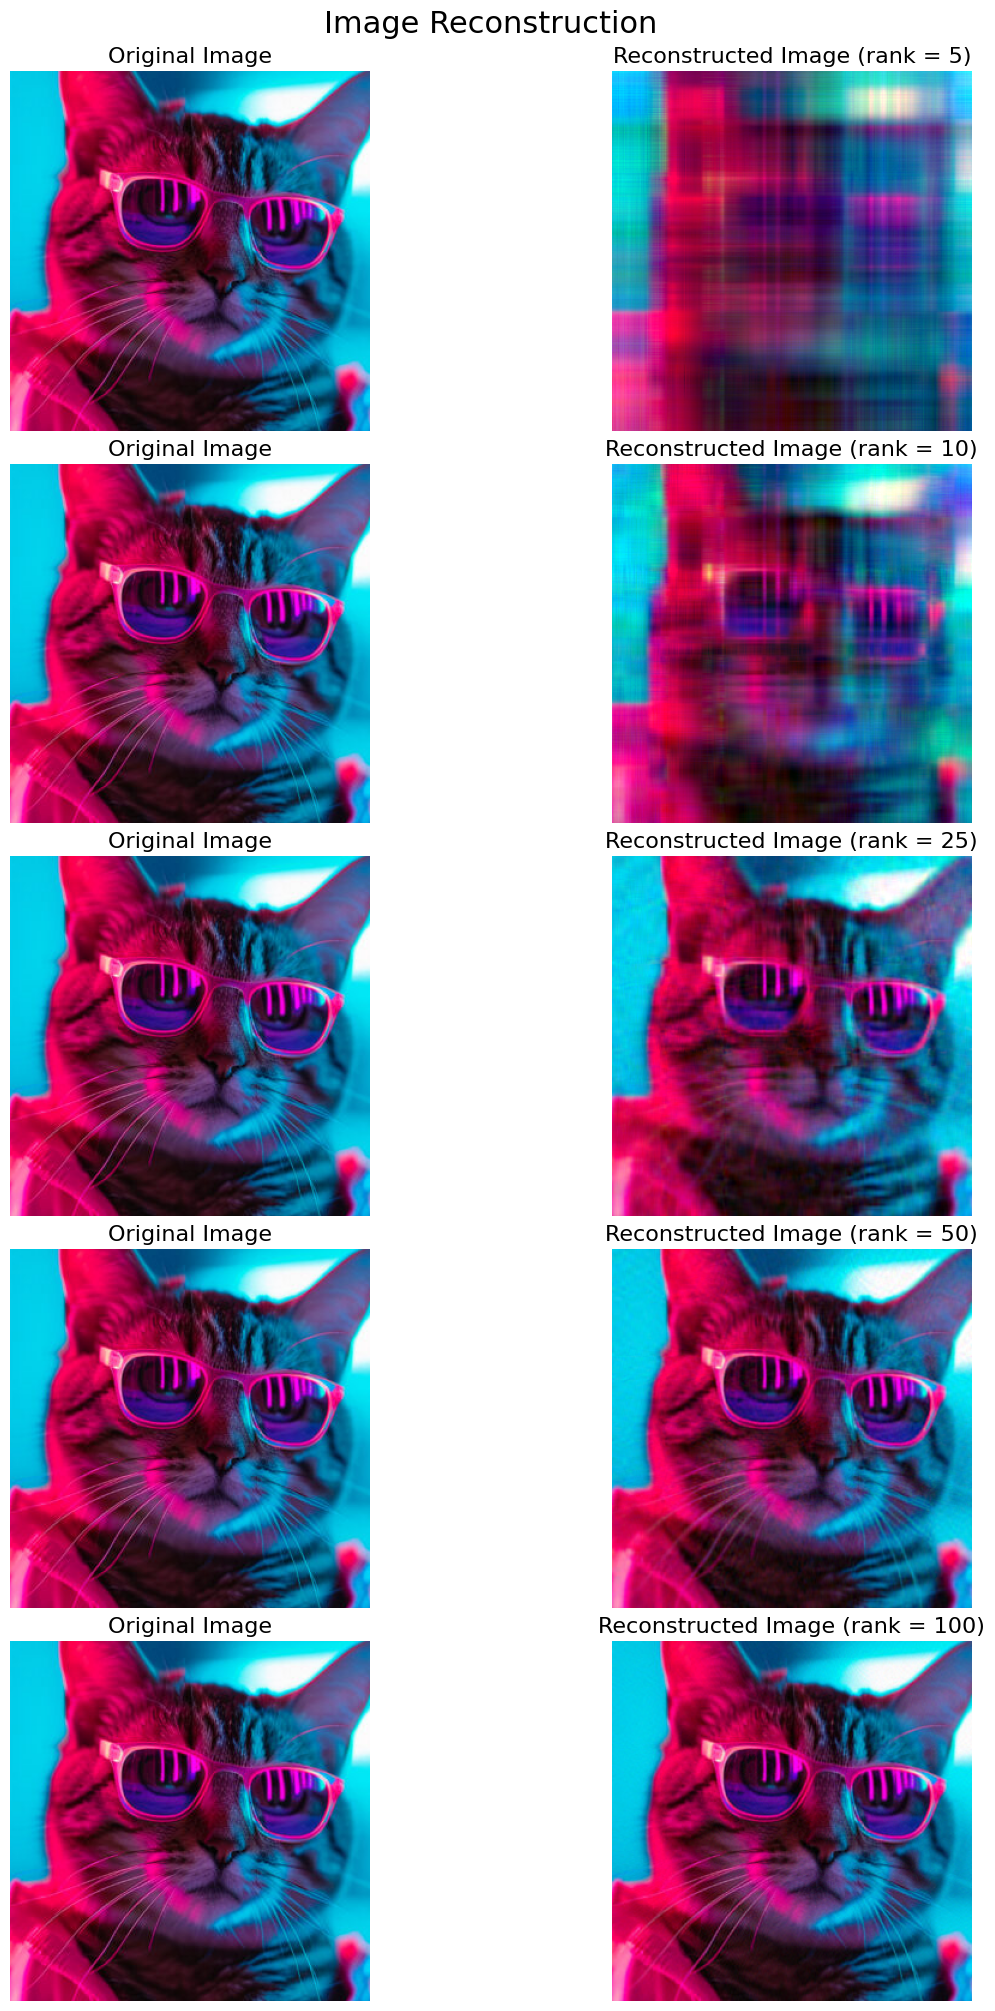

In [9]:
reconstructions = []
ranks = []

for r in [5, 10, 25, 50, 100]:
    W_red, H_red, loss_red = factorize(crop1[0], r)
    W_green, H_green, loss_green = factorize(crop1[1], r)
    W_blue, H_blue, loss_blue = factorize(crop1[2], r)
    red_reconstructed = torch.mm(W_red, H_red)
    green_reconstructed = torch.mm(W_green, H_green)
    blue_reconstructed = torch.mm(W_blue, H_blue)
    reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
    reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
    reconstructed_img = reconstructed_img.to(torch.uint8)
    reconstructions.append(reconstructed_img)
    ranks.append(r)
    rmse_patch, psnr_patch = calculate_metrics(normalize(crop1), normalize(reconstructed_img))
    
    print("\nMatrix Rank =", r)
    print("The Peak signal to noise ratio is:", psnr_patch)
    print("The Root mean square error is:", rmse_patch)
    print()
plot_images(crop1, reconstructions, ranks)


# Observations

We can see that the image reconstruction for different rank give different results with lower rank gives a poor visual result and high RMSE/low PSNR.  This is because if we use tw lower rank matrices, the information stored in the matrices is $2*n*r$, which is smaller than the information contained to represent the image comletely, i.e. $n^2$. Another way to interpret this is, for finding a particular pixel intensity, say at (a, b), you are multiplying the ath row of the first matrix with the bth column of the second matrix. If the rank is bigger, we will have more tunable parameters for fitting all pixel values, thus increasing the image quality.

**PART 2**

Function masked image takes in a image and depending on the proportion, it removes pixels (replaces the RBG values with Nan) and outputs the missing image

In [10]:
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape[1:]) < prop
    mask_rgb = mask.unsqueeze(0).repeat(img.shape[0], 1, 1)
    img_copy[mask_rgb] = float('nan')
    
    return img_copy, mask_rgb

After masking, the rest of the code is similar to the above part 1

In [11]:
masked_img = mask_image(crop1, 0.01)

In [12]:
W_red, H_red, loss_red = factorize(masked_img[0][0], 50)
W_green, H_green, loss_green = factorize(masked_img[0][1], 50)
W_blue, H_blue, loss_blue = factorize(masked_img[0][2], 50)

In [13]:
red_reconstructed = torch.mm(W_red, H_red)
green_reconstructed = torch.mm(W_green, H_green)
blue_reconstructed = torch.mm(W_blue, H_blue)
reconstructed_img = torch.stack([red_reconstructed, green_reconstructed, blue_reconstructed], dim=0)
reconstructed_img = torch.clamp(reconstructed_img, 0, 255)
reconstructed_img = reconstructed_img.to(torch.uint8)


In [14]:
def plot_images2(original, masked, reconstructed):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    axes[2].imshow(reconstructed.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

C:\Users\Arjun\AppData\Local\Temp\ipykernel_17124\1805063745.py:6: RuntimeWarning: invalid value encountered in cast
  axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))


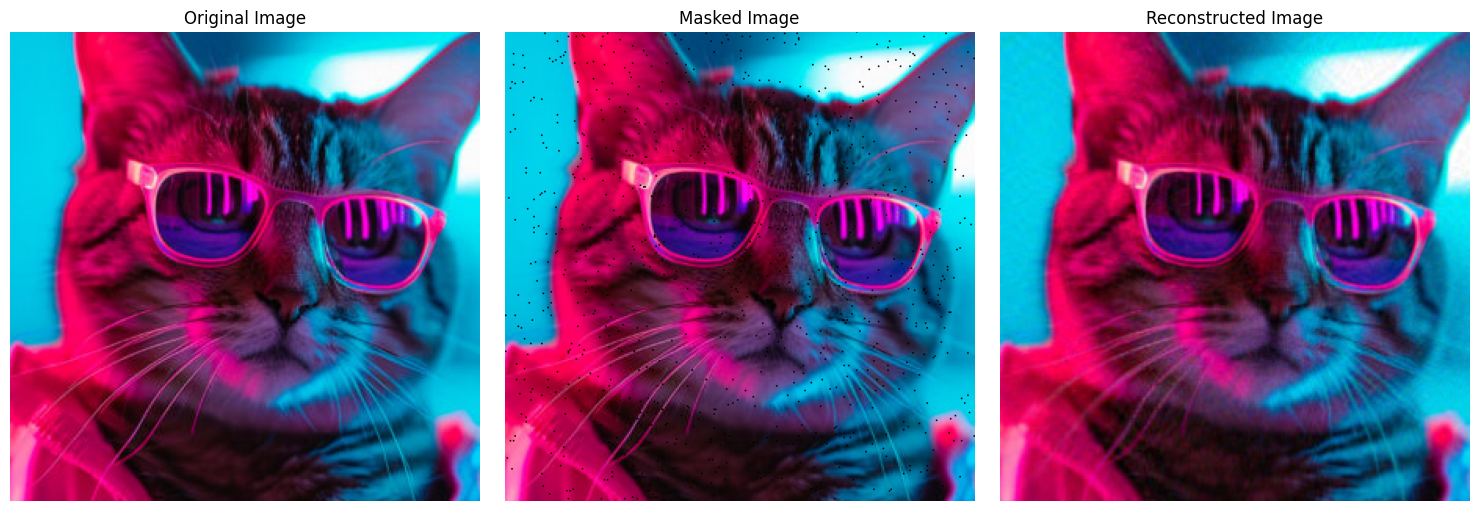

In [15]:
plot_images2(crop1, masked_img[0], reconstructed_img)

In [16]:
rmse_rand_removed , psnr_rand_removed = calculate_metrics(normalize(crop1),normalize(reconstructed_img))

print("The Peak signal to noise ratio is:", psnr_rand_removed)
print("The Root mean square error is:", rmse_rand_removed)

The Peak signal to noise ratio is: 31.37976837158203
The Root mean square error is: 0.026978112757205963


In [24]:
%%capture
img2 = torchvision.io.read_image("./images t4/cyber-kitty.jpg")
img2 = torch.tensor(img2, dtype=torch.float)
crop2 = torchvision.transforms.functional.crop(img2, 50, 230, 300, 300)

Here, instead of removing random pixels, we remove a patch for the image and then run matrix reconstruction on it. The metrics and the final visual image are then outputted

In [25]:
def mask_block_image(img, block_size, num_blocks):
    img_copy = img.clone()
    h, w = img.shape[1], img.shape[2]
    for _ in range(num_blocks):
        x = torch.randint(0, w - block_size, (1,)).item()
        y = torch.randint(0, h - block_size, (1,)).item()
        block_mask = torch.zeros((img.shape[1], img.shape[2]), dtype=torch.bool)
        block_mask[y:y+block_size, x:x+block_size] = True
        img_copy[:, block_mask] = float('nan')
    
    return img_copy, block_mask

masked_img2, mask_img2 = mask_block_image(crop2, block_size=30, num_blocks=1)

In [26]:
W2_red, H2_red, loss_red = factorize(masked_img2[0], 50)
W2_green, H2_green, loss_green = factorize(masked_img2[1], 50)
W2_blue, H2_blue, loss_blue = factorize(masked_img2[2], 50)

In [27]:
red_reconstructed2 = torch.mm(W2_red, H2_red)
green_reconstructed2 = torch.mm(W2_green, H2_green)
blue_reconstructed2 = torch.mm(W2_blue, H2_blue)
reconstructed_img2 = torch.stack([red_reconstructed2, green_reconstructed2, blue_reconstructed2], dim=0)
reconstructed_img2 = torch.clamp(reconstructed_img2, 0, 255)
reconstructed_img2 = reconstructed_img2.to(torch.uint8)

C:\Users\Arjun\AppData\Local\Temp\ipykernel_17124\1805063745.py:6: RuntimeWarning: invalid value encountered in cast
  axes[1].imshow(masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8))


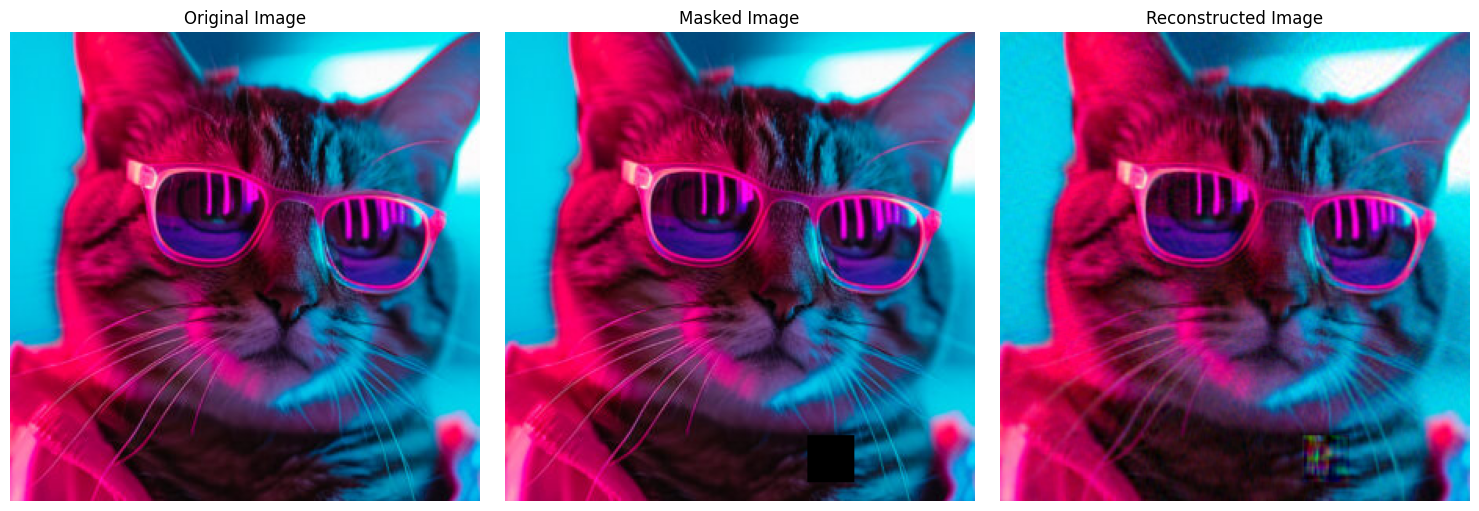

In [29]:
plot_images2(crop2, masked_img2, reconstructed_img2)

In [30]:
rmse_patch, psnr_patch = calculate_metrics(normalize(crop2),normalize(reconstructed_img2))


print("The Peak signal to noise ratio is:", psnr_patch)
print("The Root mean square error is:", rmse_patch)

The Peak signal to noise ratio is: 30.08782196044922
The Root mean square error is: 0.03130465745925903


We can observe that in the image where the patch was removed, the accuracy of the predicted values is very less as compared to random 900 missing pixels. This is because there is very little information is available in the region, therefore th predictions are poor.

**Comparasion with the RFF features + linear regression method**

First we need to remove all the coordinates for which the pixel values is `nan` and the corresponding RGB values too so that we can train our linear regression model.

In [20]:
copy_masked_img = masked_img[0].clone()

masked_img2 = copy_masked_img

X, Y = create_coordinate_map(masked_img2)
X , scaler = scale_coordinates(X)
temp = mask_img2.reshape(-1,1)

img_scaled = masked_img2/255
original_scaled = crop2/255

filtered_X = X[~torch.any(Y.isnan(),dim=1)]
filtered_Y = Y[~torch.any(Y.isnan(),dim=1)]
filtered_Y = filtered_Y / 255
print(Y)
print(Y/255)

tensor([[  1., 202., 232.],
        [  1., 202., 232.],
        [  0., 200., 228.],
        ...,
        [  0., 171., 227.],
        [  2., 159., 228.],
        [ 10., 144., 217.]])
tensor([[0.0039, 0.7922, 0.9098],
        [0.0039, 0.7922, 0.9098],
        [0.0000, 0.7843, 0.8941],
        ...,
        [0.0000, 0.6706, 0.8902],
        [0.0078, 0.6235, 0.8941],
        [0.0392, 0.5647, 0.8510]])


We create RFF features for the coordinates and then filter out the ones for which the RGB values are not `nan` so that we can use them for training.

In [34]:
X_rff = create_rff_features(X, 40000, 0.008).to(device)
X_rff_filtered = X_rff[~torch.any(Y.isnan(),dim=1)]

In [35]:
X_rff_filtered.shape
net = LinearModel(X_rff_filtered.shape[1], 3).to(device)
train(net, 0.005, X_rff_filtered.to(device), filtered_Y.to(device), 2000)

Epoch 0 loss: 0.219264


Epoch 100 loss: 0.041319
Epoch 200 loss: 0.022872
Epoch 300 loss: 0.013577
Epoch 400 loss: 0.008074
Epoch 500 loss: 0.004829
Epoch 600 loss: 0.002951
Epoch 700 loss: 0.001885
Epoch 800 loss: 0.001288
Epoch 900 loss: 0.000954
Epoch 1000 loss: 0.000766
Epoch 1100 loss: 0.000658
Epoch 1200 loss: 0.000594
Epoch 1300 loss: 0.000556
Epoch 1400 loss: 0.000532
Epoch 1500 loss: 0.000516
Epoch 1600 loss: 0.000505
Epoch 1700 loss: 0.000498
Epoch 1800 loss: 0.000493
Epoch 1900 loss: 0.000488


0.00048493294161744416

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


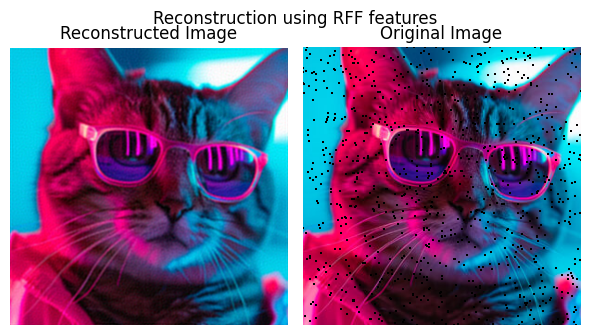

In [43]:
_ = plot_reconstructed_and_original_image(masked_img2/255, net, X_rff, title="Reconstruction using RFF features")

We then calculate the metrics for the prediction v/s the original unmasked image.

In [42]:
rmse_rff, psnr_rff = calculate_metrics(_.cpu(), (original_scaled.permute(1,2,0)))

print("The Peak signal to noise ratio is:", psnr_rff)
print("The Root mean square error is:", rmse_rff)

The Peak signal to noise ratio is: 33.10413360595703
The Root mean square error is: 0.022120419889688492
